## Post processing
$$
T_{\text{post}} (\hat x_f) = \frac{1}{2} \{ \tanh [20( \hat x_f - x_f - \epsilon )] -  \tanh [20( \hat x_f - x_f + \epsilon )]  \} + 1
$$

lo cual nos entregara distintos valores dependiendo de la distancia entre los puntos finales
- $\hat x_f$ la posición final predicha por el modelo
- $x_f$ la posición final real
- $\epsilon$ la distancia permitida entre los puntos

dado esto funciona tal que:
- $T_{\text{post}} ( | \hat x_f - x_f | \leq \epsilon ) \approx 0$
- $T_{\text{post}} ( | \hat x_f - x_f | > \epsilon ) \approx 1$


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def activation_function_tpost(x, xreal, epsilon):
    """function of activation used in the construction of T_postprocessing layer"""
    jump_force = 10
    tanh_results = torch.tanh( jump_force * (x - xreal - epsilon)) - torch.tanh( jump_force * (x - xreal + epsilon))
    return 1 + ( tanh_results ) 

In [23]:
# trying out this function
x = torch.tensor(np.linspace(1000,5000, 1000))
xreal, epsilon = 3000, 1e-1
t_output = activation_function_tpost(x, xreal, epsilon)

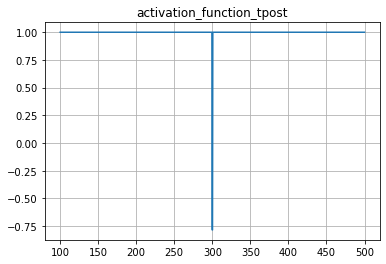

In [24]:
plt.plot(x, 1+ 50*( torch.tanh(20 * (x - xreal - epsilon)) - torch.tanh(20 * (x - xreal + epsilon)) ) ) 
plt.title("activation_function_tpost")
plt.grid()
plt.show()

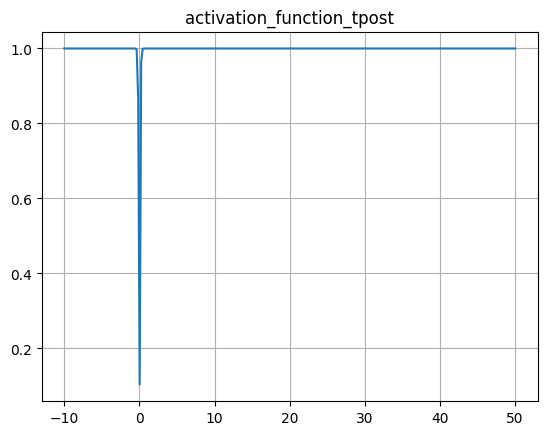

In [85]:
plt.plot(x, t_output)
plt.title("activation_function_tpost")
plt.grid()
plt.show()

In [ ]:
def Tpost(X, xreal = 0, epsilon = 1e-3):
    """
    X takes a tensor and compares its position coordinate
    to the xreal, if its inside a given distance, the function returns 0
    else it will return 1
    """

    if len(list(X.shape)) == 1: # one data point case
        x, v = X[0], X[1]
    else:
        x, v = X[:,0], X[:,1]

    # if x its close to xreal, this will return close to 0
    # else it returns close to 1
    activation_result = activation_function_tpost(x, xreal, epsilon)
    
    print("on post processing, activation result was:")
    print(activation_result)


    if (activation_result >= epsilon): # if K is not close to 0
        v = torch.zeros(len(v))

    return torch.stack([activation_result, v]).T

In [19]:
import torch
from torch import nn

class T_postprocessing(nn.Module):
    """
    X takes a tensor and compares its position coordinate
    to the xreal, if its inside a given distance, the function returns 0
    else it will return 1

    if the return is close to 0, it gives out the velocity as well
    """
    import torch
    from torch import nn
    import matplotlib.pyplot as plt
    import numpy as np
    def __init__(self, xreal = 0, epsilon = 1e-3):
        super(T_postprocessing, self).__init__()
        self.xreal = xreal
        self.epsilon = epsilon
        
        
    def forward(self, X):
        if len(list(X.shape)) == 1: # one data point case
            x, v = X[0], X[1]
        else:
            x, v = X[:,0], X[:,1]

        # if x its close to xreal, this will return close to 0
        # else it returns close to 1
        activation_result = activation_function_tpost(x, xreal, epsilon)
        
        print("on post processing, activation result was:")
        print(activation_result)


        if (activation_result >= epsilon): # if K is not close to 0
            v = torch.zeros(len(v))

        return torch.stack([activation_result, v]).T



In [20]:
xreal, epsilon = 0, 1e-3
tpost =T_postprocessing(xreal, epsilon)

# how the data should be passed
X1 = torch.tensor([[300,100]])
X = torch.tensor([[300,100], [340, 230]])

print(tpost.forward(X1))
print(tpost.forward(X))

on post processing, activation result was:
tensor([1.5000])
tensor([[1.5000, 0.0000]])
on post processing, activation result was:
tensor([1.5000, 1.5000])


RuntimeError: ignored

# 1. Redifining how the force function works

Actual pitfalls:
- its fixed and then data is generated, it should be the other way
- cant allow negative values
- only works on integers values because of the interpolation part


Ideas to fix it:
- Generate or read data, then with the information generate the Network
- `x` -> `percentage with respect to limitsX,V`

How the percentage works mathematically:

This obtains the percentage from the data point X
$$
Y \% = \frac{X - \text{lowlimit}}{ \text{upplimit} - \text{lowlimit}} \cdot 100 \%
$$

Obtains the data point X from the percentage
$$
X = (\text{upplimit} - \text{lowlimit}) \frac{Y}{100} + \text{lowlimit}
$$

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class F_percentage_function(nn.Module):
    """
    Activation function for fitting, works by saving points in a parametrized array
    its domain is constructed with lower_limit and upper_limit
    then the ammount of points it contains is decided with N

    this is the advanced version of F_function
    """
    import torch
    from torch import nn
    import matplotlib.pyplot as plt
    import numpy as np
    def __init__(self, N, lower_limit, upper_limit, dt):
        super(F_percentage_function, self).__init__()
        self.force = nn.Parameter(torch.rand(N), requires_grad=True)
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit
        
        
    def forward(self, X):
        """
        does an interpolation based on percentage, 
        - whats the percentage of the data point
        - where is the closest force point to this percentage
        - then returns [x, v + dt * selected_force]
        """

        # extracting values
        if len(list(X.shape)) == 1: # one data point case
            x, v = X[0], X[1]
        else:
            x, v = X[:,0], X[:,1]

        # percentage for selecting the force point
        y_percentage = (x - self.lower_limit)/(self.upper_limit - self.lower_limit) * 100

        # Select the component of self.force that is closest to the percentage value
        idx = torch.argmin(torch.abs(y_percentage.unsqueeze(1) - torch.arange(0, 100, 100/self.force.shape[0])), dim=1)

        # Get the selected force value
        selected_force = self.force[idx]

        # Return the updated input
        return torch.stack([x, v + dt * selected_force]).T

    def plot_force(self):
        """
        plots the force points, giving not the index but the real meaning of inputs x
        """
        force_points = np.array(self.force.detach())
        x_points = np.linspace(lower_limit, upper_limit, N)
        
        plt.plot(x_points, force_points)
        plt.xlabel("x")
        plt.ylabel("force")
        plt.show()


In [ ]:
N, lower_limit, upper_limit, dt = 1000, 100, 400, 5e-3
fper = F_percentage_function(N, lower_limit, upper_limit, dt)

# how the data should be passed
X1 = torch.tensor([[300,100]])
X = torch.tensor([[300,100], [340, 230]])

print(fper.forward(X1))
print(fper.forward(X))

tensor([[300.0000, 100.0032]], grad_fn=<PermuteBackward0>)
tensor([[300.0000, 100.0032],
        [340.0000, 230.0021]], grad_fn=<PermuteBackward0>)


In [ ]:
X_upper = torch.tensor([[400,0]])
X_overflow = torch.tensor([[500,0]])

print(fper.forward(X_upper))
print(fper.forward(X_overflow)) # overflow problem is fixed :)

tensor([[4.0000e+02, 3.5087e-03]], grad_fn=<PermuteBackward0>)
tensor([[5.0000e+02, 3.5087e-03]], grad_fn=<PermuteBackward0>)


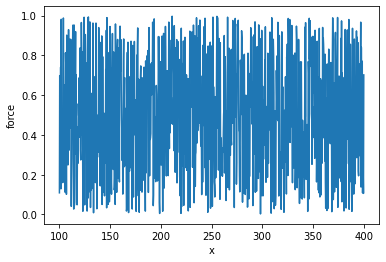

In [ ]:
fper.plot_force()


# Loading model and continuum training

In [ ]:
# run this if using local
# path where you have this file, this is mine:
base_path = r"./"

data_path = base_path + r"data/"
model_path = base_path + r"model/"

In [ ]:
from diffnet import F_function, W_matrix, diffNet, smooth_loss, physics_constrain, plot_f
from dataset import MyDataset, DataLoader
import torch
import torch.nn as nn

import pandas as pd
import glob
import matplotlib.pyplot as plt

data_file_name = "song_f3.csv"
model_file_name = "song_f3_0408_epoch232.pt"
working_date = "0409"

name_for_model = "song_f3"

batch_size = 100


In [ ]:
# Loading data
data_path = base_path + './data/'
model_path = base_path + './model/'

data = pd.read_csv( data_path + data_file_name  , index_col=0)
my_dataset = MyDataset(data)
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# creating the model first time
# model = diffNet(depth=50)

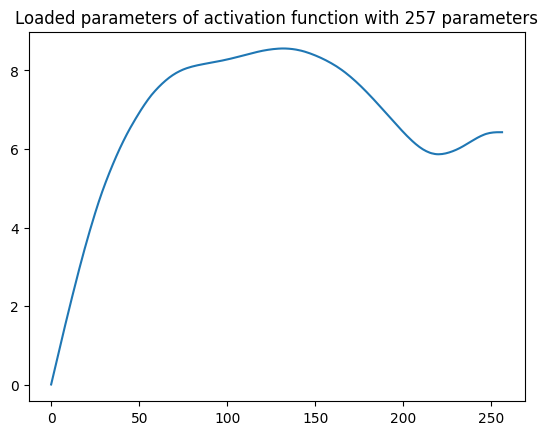

In [ ]:
# Loading the model
model = torch.load( model_path + model_file_name )
# model = torch.load(model_file_name)

plt.plot(list(model.parameters())[0].detach())
N = len(list(model.parameters())[0])
plt.title(f"Loaded parameters of activation function with {N} parameters")
plt.show()


loss_array = []
global_model_epoch = 0

In [ ]:
# ========================= Hyperparameters ====================================
smooth_rate = 5 
constrain_rate = 1.0 # F(v=0) = 0
targets_rate = 2

# Define number of epochs
num_epochs = 100

# Define loss function and optimizer
L2_loss = nn.MSELoss(reduction="sum")

optimizer = torch.optim.SGD(model.parameters(), lr=0.45)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

# ==================== end of hyperparameters ==================================

# normalization for losses
smooth_rate = smooth_rate / N
targets_rate = targets_rate / batch_size

running_loss = 0


#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        L2_computed_loss = L2_loss(outputs, targets)
        # Compute loss
        loss = (smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_computed_loss)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_computed_loss.detach().item())
            loss_array.append(L2_computed_loss.detach().item())
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 100 == 10:
        # saving the model
        torch.save(model, model_path + f"{name_for_model}_{working_date}_{global_model_epoch}+epoch{epoch}.pt")
    

# finish training
global_model_epoch += epoch +1
torch.save(model, model_path + f"{name_for_model}_{working_date}_{global_model_epoch}.pt")
print('Finished training')

L2_loss: 3.5533249378204346
[Epoch 1, Mini-batch   100] Loss: 0.098
L2_loss: 3.2502827644348145
[Epoch 1, Mini-batch   200] Loss: 0.096
L2_loss: 3.3081769943237305
[Epoch 1, Mini-batch   300] Loss: 0.097
L2_loss: 3.4954352378845215
[Epoch 1, Mini-batch   400] Loss: 0.097
L2_loss: 3.7099666595458984
[Epoch 1, Mini-batch   500] Loss: 0.097
L2_loss: 3.5183262825012207
[Epoch 1, Mini-batch   600] Loss: 0.098
L2_loss: 3.7533509731292725
[Epoch 1, Mini-batch   700] Loss: 0.097
L2_loss: 3.6665782928466797
[Epoch 1, Mini-batch   800] Loss: 0.097
L2_loss: 3.5087738037109375
[Epoch 2, Mini-batch   100] Loss: 0.148
L2_loss: 3.5693116188049316
[Epoch 2, Mini-batch   200] Loss: 0.097
L2_loss: 3.700058937072754
[Epoch 2, Mini-batch   300] Loss: 0.097
L2_loss: 3.815457820892334
[Epoch 2, Mini-batch   400] Loss: 0.097
L2_loss: 3.5506465435028076
[Epoch 2, Mini-batch   500] Loss: 0.097
L2_loss: 3.733250141143799
[Epoch 2, Mini-batch   600] Loss: 0.097
L2_loss: 3.742058277130127
[Epoch 2, Mini-batch   7

KeyboardInterrupt: ignored

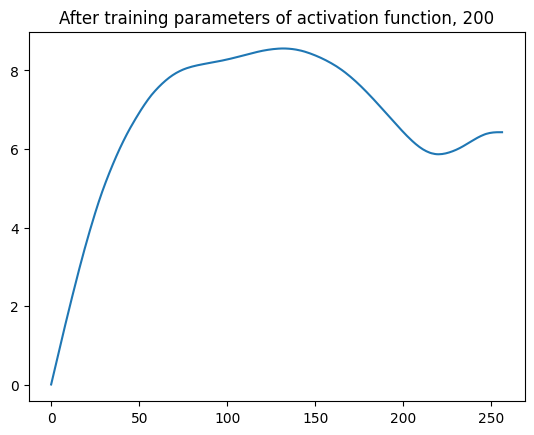

In [ ]:
plt.plot(list(model.parameters())[0].detach())
plt.title(f"After training parameters of activation function, {global_model_epoch}")
plt.show()

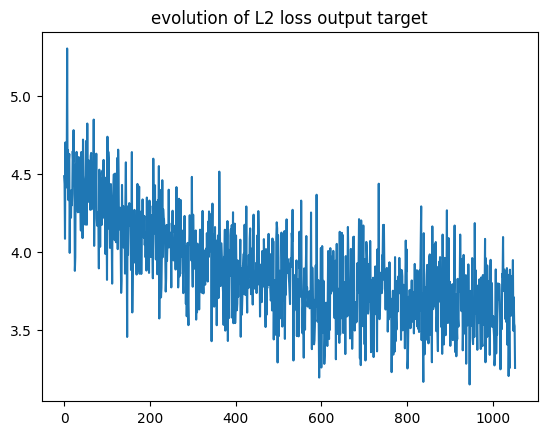

In [ ]:
# plot loss
plt.plot(loss_array)
plt.title(f"L2 loss {global_model_epoch}, smth: {smooth_rate}, tgts: {targets_rate} ")
plt.savefig(f"{base_path}evolution_force")
plt.show()

In [ ]:
global_model_epoch =+ 32

In [ ]:
# saving the model
torch.save(model, f"{model_path}{name_for_model}_{working_date}_epoch{global_model_epoch}.pt")

In [ ]:
# save loss as csv
pd.DataFrame(loss_array).to_csv(f"{model_path}loss_{name_for_model}_epoch{global_model_epoch}.csv")